# Step - 1 Load the dataset

In [1]:
from sklearn.datasets import load_diabetes

import numpy as np
import pandas as pd

# Load the dataset

diabetes = load_diabetes(as_frame=True)

X = diabetes.data
y = diabetes.target

# Combine feature + target for outlier detection

data = pd.concat([X,y.rename("target")],axis=1)
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


# Methods to Detect Outliers

# Step - 2 (Z- score Method)

In [2]:
# Z - Score Method for target feature

mean = data['target'].mean()
std = data['target'].std()

data['Z_score'] = (data['target']-mean)/std

data['Z_outlier'] = data['Z_score'].abs()>3

data[['target',"Z_score","Z_outlier"]]

,target,Z_score,Z_outlier
0,151.0,-0.014703,False
1,75.0,-1.000525,False
2,141.0,-0.144416,False
3,206.0,0.698721,False
4,135.0,-0.222244,False
...,...,...,...
437,178.0,0.335524,False
438,104.0,-0.624356,False
439,132.0,-0.261158,False
440,220.0,0.880320,False


In [3]:
data[['Z_outlier']].value_counts()

,count
Z_outlier,
False,442


# Step - 3 Modified Z-score

In [4]:
median = (data['target']).median()
median

# Mean Absolute Deviation
MAD = ((data['target']-median).abs()).median()
MAD

data['mod_z'] = 0.6745 * ((data['target']-median)/MAD)

data['mod_z_outlier'] = data['mod_z'].abs()>3.5

data[['target','mod_z','mod_z_outlier']].head(10)

,target,mod_z,mod_z_outlier
0,151.0,0.119029,False
1,75.0,-0.742517,False
2,141.0,0.005668,False
3,206.0,0.742517,False
4,135.0,-0.062349,False
5,97.0,-0.493122,False
6,138.0,-0.028340,False
7,63.0,-0.878550,False
8,110.0,-0.345752,False
9,310.0,1.921475,False


In [5]:
data[['mod_z_outlier']].value_counts()

,count
mod_z_outlier,
False,442


# Step - 4 IQR Method

In [6]:
Q1 = data['target'].quantile(0.25)

Q3 = data['target'].quantile(0.75)

IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR

upper_bound = Q3 + 1.5*IQR

data['iqr_outlier'] = (data['target']<lower_bound) | (data['target']>upper_bound)

data[['target','iqr_outlier']].head(10)

,target,iqr_outlier
0,151.0,False
1,75.0,False
2,141.0,False
3,206.0,False
4,135.0,False
5,97.0,False
6,138.0,False
7,63.0,False
8,110.0,False
9,310.0,False


In [7]:
data[['iqr_outlier']].value_counts()

,count
iqr_outlier,
False,442


# Step - 5 Box Plot

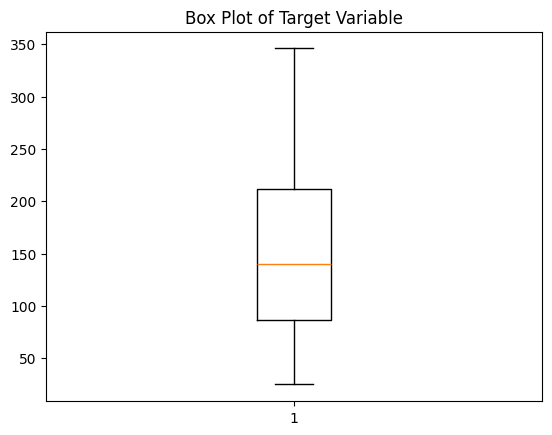

In [8]:
import matplotlib.pyplot as plt

plt.boxplot(data['target'])
plt.title("Box Plot of Target Variable")
plt.show()

# Step - 6 Isolation Forest

In [9]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05,random_state=42)

data['iso_outlier'] = iso.fit_predict(data[['target']])

data['iso_outlier'] = data['iso_outlier'].map({1:False,-1:True})

data[['target','iso_outlier']].head(10)

,target,iso_outlier
0,151.0,False
1,75.0,False
2,141.0,False
3,206.0,False
4,135.0,False
5,97.0,False
6,138.0,False
7,63.0,False
8,110.0,False
9,310.0,True


In [10]:
data[['iso_outlier']].value_counts()

# Contamination = 0.05
# total outliers = 442(total record) * 0.05 = ~23 outliers

,count
iso_outlier,
False,419
True,23


# Step - 7 Local Outlier Factor(LOF)

In [11]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20,contamination=0.05)

label = lof.fit_predict(data[['target']])

data['lof_outlier'] = label == -1

print(data[['target','lof_outlier']])


     target  lof_outlier
0     151.0        False
1      75.0        False
2     141.0        False
3     206.0        False
4     135.0        False
..      ...          ...
437   178.0        False
438   104.0        False
439   132.0        False
440   220.0        False
441    57.0        False

[442 rows x 2 columns]


In [12]:
data[['lof_outlier']].value_counts()

,count
lof_outlier,
False,419
True,23


# Step - 7 One - Class SVM

In [13]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.05,gamma='scale')

labels = ocsvm.fit_predict(data[['target']])

data['svm_outlier']=labels ==-1

print(data[['target','svm_outlier']])

     target  svm_outlier
0     151.0        False
1      75.0        False
2     141.0        False
3     206.0        False
4     135.0         True
..      ...          ...
437   178.0        False
438   104.0        False
439   132.0         True
440   220.0        False
441    57.0        False

[442 rows x 2 columns]


In [14]:
data[['svm_outlier']].value_counts()

,count
svm_outlier,
False,397
True,45


# Step - 8 DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=30,min_samples=5)

labels = db.fit_predict(data[['target']])

data['dbscan_outlier'] = labels == -1

data[['target','dbscan_outlier']]

,target,dbscan_outlier
0,151.0,False
1,75.0,False
2,141.0,False
3,206.0,False
4,135.0,False
...,...,...
437,178.0,False
438,104.0,False
439,132.0,False
440,220.0,False


In [16]:
data[['dbscan_outlier']].value_counts()

,count
dbscan_outlier,
False,442


# Step - 9 Compare all methods

In [17]:
methods = ["Z_outlier", "mod_z_outlier", "iqr_outlier",
           "iso_outlier", "lof_outlier", "svm_outlier", "dbscan_outlier"]

outlier_summary = data[methods].sum()
print(outlier_summary)


Z_outlier          0
mod_z_outlier      0
iqr_outlier        0
iso_outlier       23
lof_outlier       23
svm_outlier       45
dbscan_outlier     0
dtype: int64


# Handling Outliers

# Step - 1 Dropping Outliers

In [18]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05,random_state=42)

data['iso_outlier'] = iso.fit_predict(data[['target']])

data['iso_outlier'] = data['iso_outlier'].map({1:False,-1:True})

print(data[['target','iso_outlier']].head(10))

print("\n")

print(data[['iso_outlier']].value_counts())

print("\n")

# Dropping Outliers

data_drop = data[~data['iso_outlier']]

print(data.shape,data_drop.shape)


   target  iso_outlier
0   151.0        False
1    75.0        False
2   141.0        False
3   206.0        False
4   135.0        False
5    97.0        False
6   138.0        False
7    63.0        False
8   110.0        False
9   310.0         True


iso_outlier
False          419
True            23
Name: count, dtype: int64


(442, 20) (419, 20)


# Step - 2 Capping / Winsorization

In [19]:
# Replace the Outliers with nearest valid value

lower_cap = data['target'].quantile(0.05)

upper_cap = data['target'].quantile(0.95)

# Using pandas clip() method cap the values

data['capped_values'] = data['target'].clip(lower=lower_cap,upper=upper_cap)
data[['capped_values']].head()

,capped_values
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


# Step - 3 Transformations

In [20]:
# Applying Yeo - Johnson Transformation
# It works for the negative values as well.

from sklearn.preprocessing import PowerTransformer

power_transformation = PowerTransformer(method="yeo-johnson")

data['power_transform'] = power_transformation.fit_transform(data[['target']])

data[['power_transform']].head(10)

,power_transform
0,0.163438
1,-1.027849
2,0.034644
3,0.783857
4,-0.045643
5,-0.620755
6,-0.005202
7,-1.285148
8,-0.409094
9,1.699368


# Step - 4 Binning

In [21]:
# Convert Continuous Values into categories

import pandas as pd

data['target_bins'] = pd.qcut(data['target'],q=5,labels=False)

print(data[['target_bins']].head(10))

print("\n")

print(data[['target_bins']].value_counts())



   target_bins
0            2
1            0
2            2
3            3
4            2
5            1
6            2
7            0
8            1
9            4


target_bins
0              91
2              89
4              88
1              87
3              87
Name: count, dtype: int64


# Step - 5 Robust Models

In [22]:
from sklearn.linear_model import HuberRegressor,RANSACRegressor

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

# Fit the Robust Model

huber = HuberRegressor().fit(X_train,y_train)
ransac = RANSACRegressor().fit(X_train,y_train)

print("Huber R2 : ", huber.score(X_test,y_test))

print("RANSAC R2 : ", ransac.score(X_test,y_test))

Huber R2 :  0.48274516148630797
RANSAC R2 :  0.05110133127301253


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
